# Eigenfaces
In this notebook we will work on "Eigenfaces" with PCA
To do so we will work firstly only on the olivetti faces data set and then create add our own faces to the dataset.

In [1]:
import sys 
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_olivetti_faces 

(400, 4096)


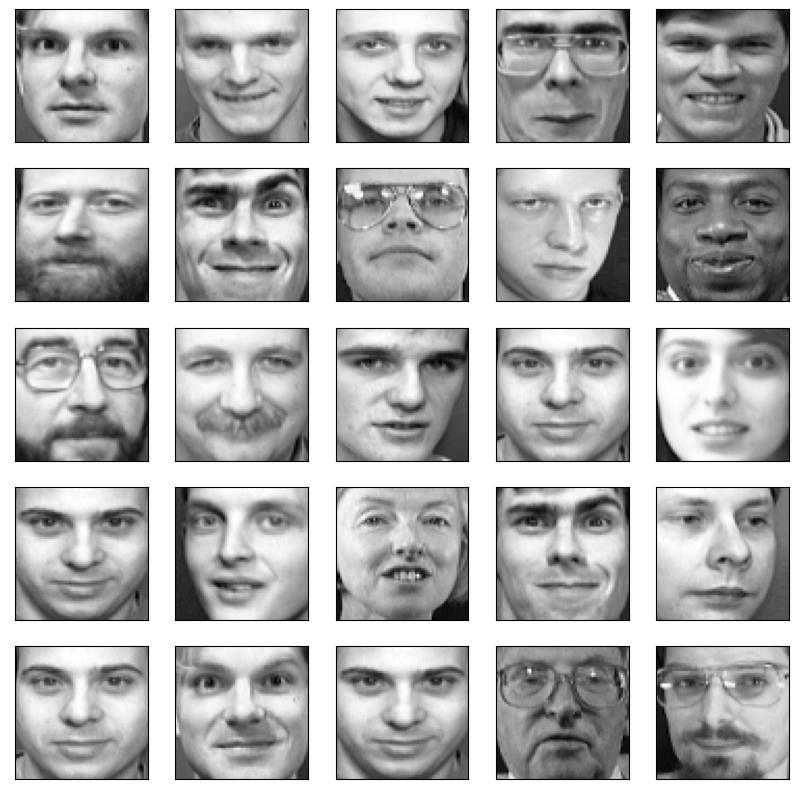

In [2]:
faces = fetch_olivetti_faces().data
print(faces.shape)
fig = plt.figure(figsize=(10, 10))

j =1 
np.random.seed(0)
for i in np.random.choice(range(faces.shape[0]), 25): 
    ax = fig.add_subplot(5,5,j,xticks=[], yticks=[])
    ax.imshow(np.reshape(faces[i], (64, 64)), cmap=plt.cm.gray)
    j += 1

plt.show()

In [3]:
# Other dataset
# orig_imaages = sorted(Path("./rawdata").rglob("*.jpg")+sorted)
# min_rows, min_cols = sys.maxsize, sys.maxsize
# max_rows, max_cols = 0, 0
# for (i,image) in enumerate(orig_images):
#     r,c = image.shape[0], image.shape[1]
#     min_rows = min(min_rows, r)
#     min_cols = min(min_cols, c)
#     max_rows = max(max_rows, r)
#     max_cols = max(max_cols, c)

# print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")

In [4]:
print(faces.shape)
print(len(faces))

(400, 4096)
400


In [5]:
# images into matrix
m = len (faces)
d = 64 * 64
X = np.reshape(faces, (m, d))

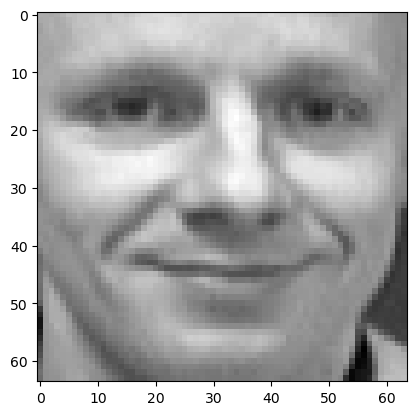

In [6]:
# and back to image
plt.imshow(np.reshape(X[int(len(X)/2), :], (64, 64)), cmap = 'gray')

In [7]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

In [8]:
print(X)
print(U)
print(Sigma)
print(VT.shape)

[[0.30991736 0.3677686  0.41735536 ... 0.15289256 0.16115703 0.1570248 ]
 [0.45454547 0.47107437 0.5123967  ... 0.15289256 0.15289256 0.15289256]
 [0.3181818  0.40082645 0.49173555 ... 0.14049587 0.14876033 0.15289256]
 ...
 [0.5        0.53305787 0.607438   ... 0.17768595 0.14876033 0.19008264]
 [0.21487603 0.21900827 0.21900827 ... 0.57438016 0.59090906 0.60330576]
 [0.5165289  0.46280992 0.28099173 ... 0.35950413 0.3553719  0.38429752]]
[[-0.05747153 -0.01133889 -0.04220835 ...  0.01559427 -0.03336829
   0.0131074 ]
 [-0.05323787  0.09539696  0.03045294 ... -0.03961178  0.0016255
  -0.01438268]
 [-0.05639288  0.00501834 -0.00853068 ...  0.00164818  0.03053788
  -0.01101169]
 ...
 [-0.0476642   0.03023936  0.07094702 ...  0.03952542 -0.02635706
  -0.00507093]
 [-0.05386574 -0.13364863 -0.01520891 ... -0.03870142  0.00949335
   0.02251499]
 [-0.05078684 -0.03742086  0.02501281 ... -0.1176764  -0.01148989
   0.03879915]]
[717.22144     67.45447     50.51128     40.18347     36.337997
 

(400, 50)


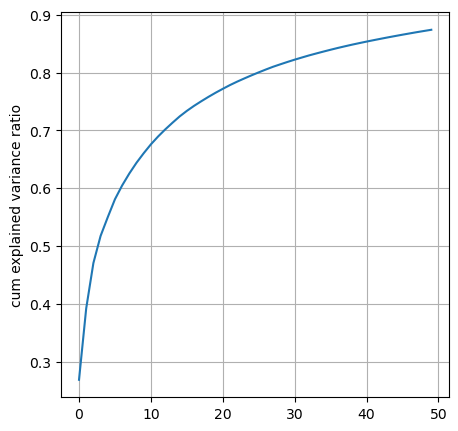

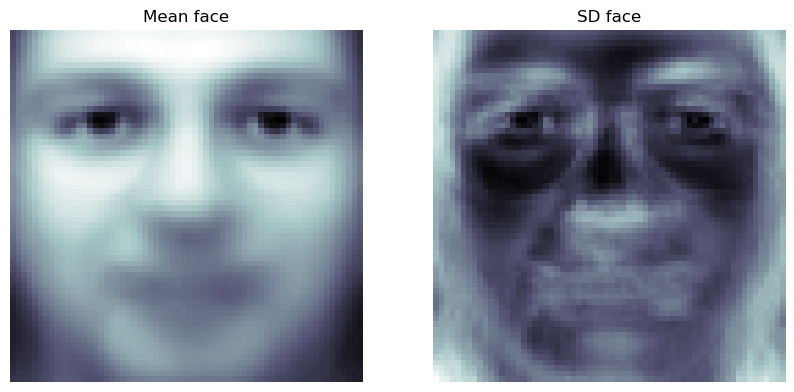

In [9]:
n_comp = 50
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components = n_comp))])
faces_proj = pipeline.fit_transform(faces)
print(faces_proj.shape)

mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (64, 64))
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (64, 64)) # variance 
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_))
plt.grid() , plt.ylabel("cum explained variance ratio")
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(121), plt.imshow(mean_face, cmap=plt.cm.bone), plt.axis('off'), plt.title('Mean face')
plt.subplot(122), plt.imshow(sd_face, cmap=plt.cm.bone), plt.axis('off'), plt.title('SD face')
plt.show() 

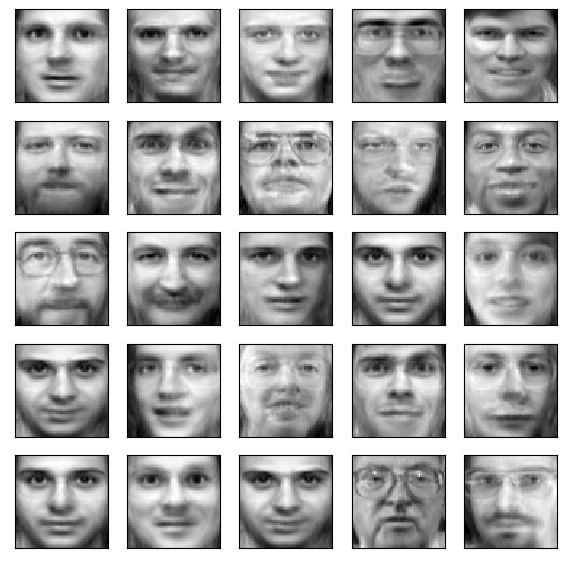

In [10]:
# reconstruction of faces
face_inv_proj = pipeline.named_steps['pca'].inverse_transform(faces_proj)
fig = plt.figure (figsize=(7,7))

j = 1 
np.random.seed(0)
for i in np.random.choice(range(faces.shape[0]), 25):
    ax = fig.add_subplot(5,5, j, xticks=[], yticks=[])
    ax.imshow(mean_face + sd_face * np.reshape(face_inv_proj, (400,64,64)) [i,:] ,cmap='gray',interpolation='nearest')
    j += 1

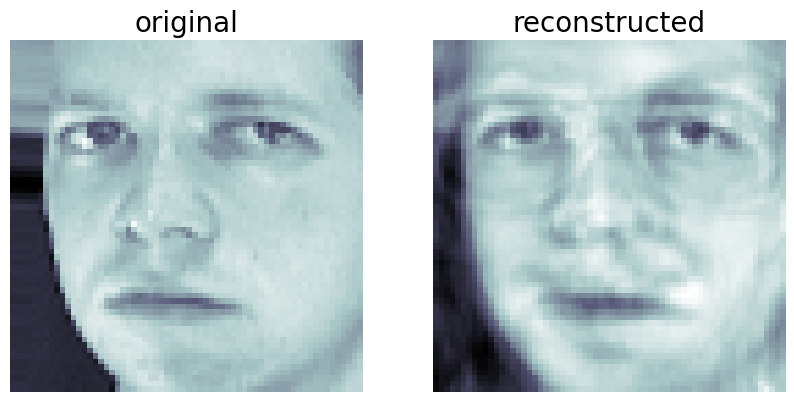

In [11]:
n_comp = 1000
orig_face = np.reshape(faces[5,:], (64,64))
reconst_face = np.reshape(faces_proj[5,:]@pipeline.named_steps['pca'].components_, (64,64))
reconst_face = mean_face + sd_face*reconst_face
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(orig_face, cmap=plt.cm.bone, interpolation='nearest'), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(reconst_face, cmap=plt.cm.bone, interpolation='nearest'), plt.axis('off'), plt.title('reconstructed', size=20)
plt.show()

___
# Own faces reconstruction

In the following we will now see at what point (after what number of iterations we can recognise our selfs in the reconstruction)
Therefore we need to:

- load our own pictures
- size them and grayscale them to the same size
- Add them to the dataset 
- Reconstruct our faces with the PCA pipeline



In [12]:
from sklearn.utils import Bunch 

(2, 64, 64)


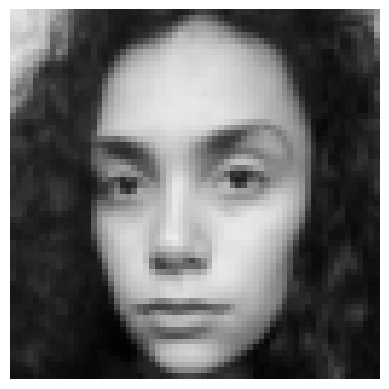

In [13]:
# loading our own images, rescaling them and rescaling the to 64x64
path = Path("./team_faces")
img_size = 64
n_img = 2

orig_images = sorted(path.rglob("*.png"))

def center_square_crop(img: Image.Image) -> Image.Image:
    """Crop the largest centred square out of an image."""
    w, h = img.size
    side = min(w, h)
    left   = (w - side) // 2
    top    = (h - side) // 2
    right  = left + side
    bottom = top  + side
    return img.crop((left, top, right, bottom))

processed_img = []

for img in orig_images:
    with Image.open(img) as im: 
        im = im.convert("L")
        im = center_square_crop(im)
        im = im.resize((img_size, img_size), Image.BILINEAR)
        processed_img.append(np.asarray(im, dtype=np.float32) / 255.0)

data = np.stack(processed_img)
print(data.shape)

plt.imshow(data[0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()


In [14]:
# adding our faces to the oli dataset
oli = fetch_olivetti_faces() 

new_imgs = data

assert new_imgs.shape[1:] == (64, 64),"Images must be 64×64"
assert new_imgs.min() >= 0 and new_imgs.max() <= 1,"Images must be 0,1"

# Reshape the images to 2D
new_flat = new_imgs.reshape(len(new_imgs), -1)
X_enlarged = np.vstack([oli.data, new_flat])
imgs_enlarged = np.concatenate([oli.images, new_imgs])
new_labels = np.full(len(new_imgs), oli.target.max() + 1, dtype=int)  # 40
y_enlarged = np.concatenate([oli.target, new_labels])


oli_plus = Bunch(
    data   = X_enlarged,
    images = imgs_enlarged,
    target = y_enlarged,
    DESCR  = oli.DESCR + "\n\n(2 extra custom images appended)."
)

print(oli_plus.data.shape, oli_plus.images.shape, oli_plus.target[-2:])

(402, 4096) (402, 64, 64) [40 40]


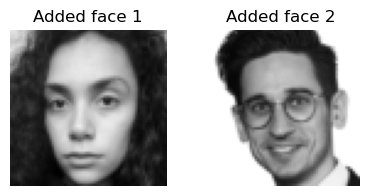

In [15]:
added_imgs = oli_plus.images[-2:]

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for idx, ax in enumerate(axes):
    ax.imshow(added_imgs[idx], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Added face {idx+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()


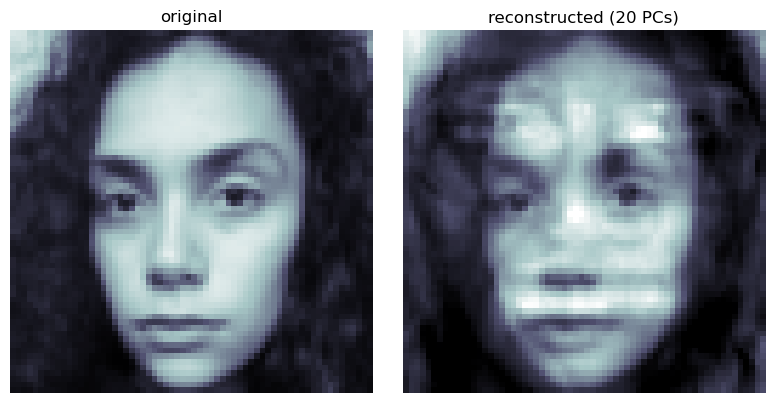

In [16]:
n_comp = 20
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_comp))])

pipeline.fit(oli_plus.data)

idx = 400                              
x = oli_plus.data[[idx]]          
x_reconst = pipeline.inverse_transform(pipeline.transform(x))
orig_face = x.reshape(64, 64)
reconst_face= x_reconst.reshape(64, 64)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_face,   cmap='bone', vmin=0, vmax=1)
plt.title("original");    plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconst_face, cmap='bone', vmin=0, vmax=1)
plt.title(f"reconstructed ({n_comp} PCs)"); plt.axis('off')
plt.tight_layout(); plt.show()


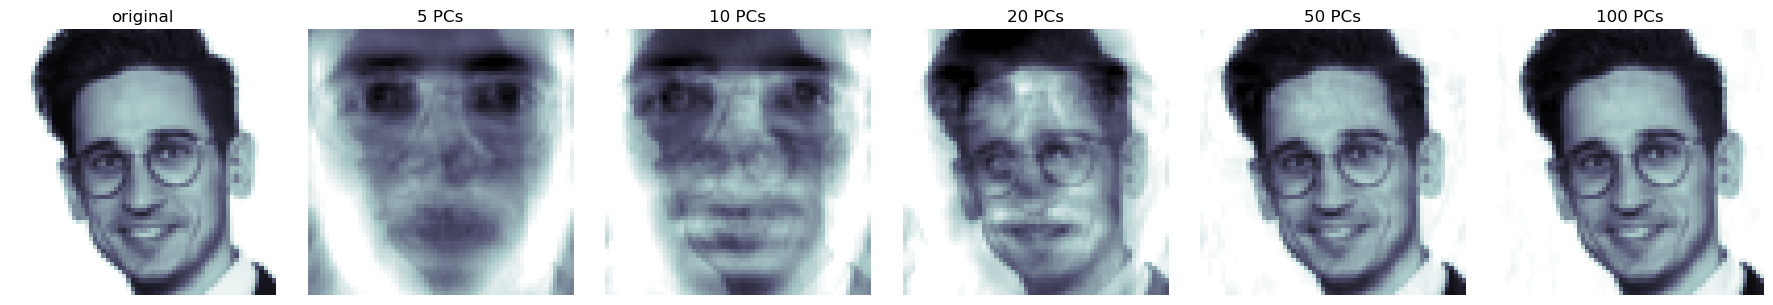

In [17]:
# Now same for me and lets try plotting with differenc ncomp
n_comp_list  = [5, 10, 20, 50, 100]
x = oli_plus.data[[401]] 
reconstructed = []

for n_comp in n_comp_list:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_comp))
    ])
    pipe.fit(oli_plus.data)                      
    x_reconst = pipe.inverse_transform(pipe.transform(x))
    reconstructed.append((n_comp, x_reconst.reshape(64, 64)))


cols = 1 + len(reconstructed)                    
fig, axes = plt.subplots(1, cols, figsize=(3*cols, 3))

axes[0].imshow(x.reshape(64, 64), cmap='bone', vmin=0, vmax=1)
axes[0].set_title("original"); axes[0].axis('off')

for ax, (n_comp, face) in zip(axes[1:], reconstructed):
    ax.imshow(face, cmap='bone', vmin=0, vmax=1)
    ax.set_title(f"{n_comp} PCs"); ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (64, 64))

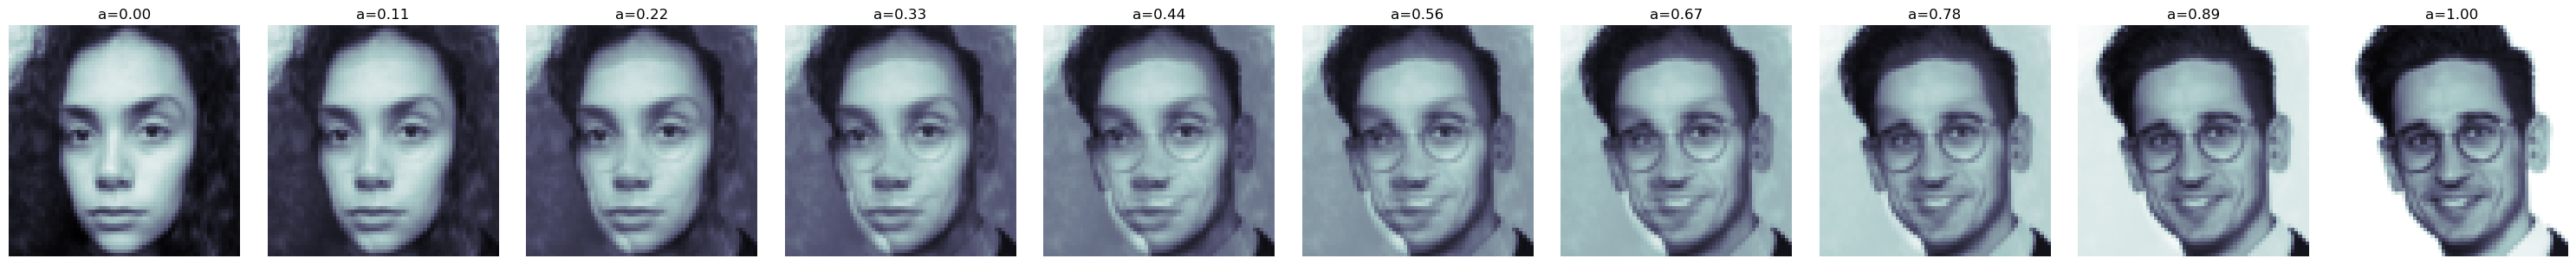

In [ ]:
n_comp = 402                  
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components=n_comp))
])
pipeline.fit(oli_plus.data)


idx_a, idx_b = -2, -1 
Xa = oli_plus.data[[idx_a]]               
Xb = oli_plus.data[[idx_b]]

Za = pipeline.transform(Xa)        
Zb = pipeline.transform(Xb)

K = 8                          
alphas = np.linspace(0, 1, K + 2)        

morphs = []
for a in alphas:
    Zm   = (1 - a) * Za + a * Zb #linearkombination der 2
    Xm   = pipeline.inverse_transform(Zm) 
    morphs.append(Xm.reshape(64, 64))


cols = len(morphs)
fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3))

for ax, img, a in zip(axes, morphs, alphas):
    ax.imshow(img, cmap='bone', vmin=0, vmax=1)
    ax.set_title(f"a={a:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
